In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score

%matplotlib inline

QUESTIONS:

* How to achieve the Best price on AirBNB Listings?
* How to achieve good reviews for the Airbnb Listings?
* Is it possible to Create an accurate predictive model for Listing price based on machine learning Techniques?



Data gathering, assessing and cleaning:


In [5]:
# Data gathering
# Import data into dataframes
calendar = pd.read_csv("./Airbnb_Seattle_Data/calendar.csv")
listings = pd.read_csv("./Airbnb_Seattle_Data/listings.csv")
reviews = pd.read_csv("./Airbnb_Seattle_Data/reviews.csv")

In [6]:
# Assessing
print("Size of dataframes, rows, columns \n", 
      "Calendar : ", calendar.shape, "\n",
      "Listings : ", listings.shape, "\n",
      "Reviews : ", reviews.shape,)

Size of dataframes, rows, columns 
 Calendar :  (1393570, 4) 
 Listings :  (3818, 92) 
 Reviews :  (84849, 6)


In [7]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

In [8]:
# Cleaning
# Create some extra features based on amenities
listings['TV'] = listings.amenities.str.contains("tv", case=False)
listings['Internet'] = listings.amenities.str.contains('internet|wireless', case=False)
listings['Parking'] = listings.amenities.str.contains('parking', case=False)
listings['Washer'] = listings.amenities.str.contains('washer', case=False)
listings['Dryer'] = listings.amenities.str.contains('dryer', case=False)
listings['AirCon'] = listings.amenities.str.contains('air condition|air conditioning', case=False)

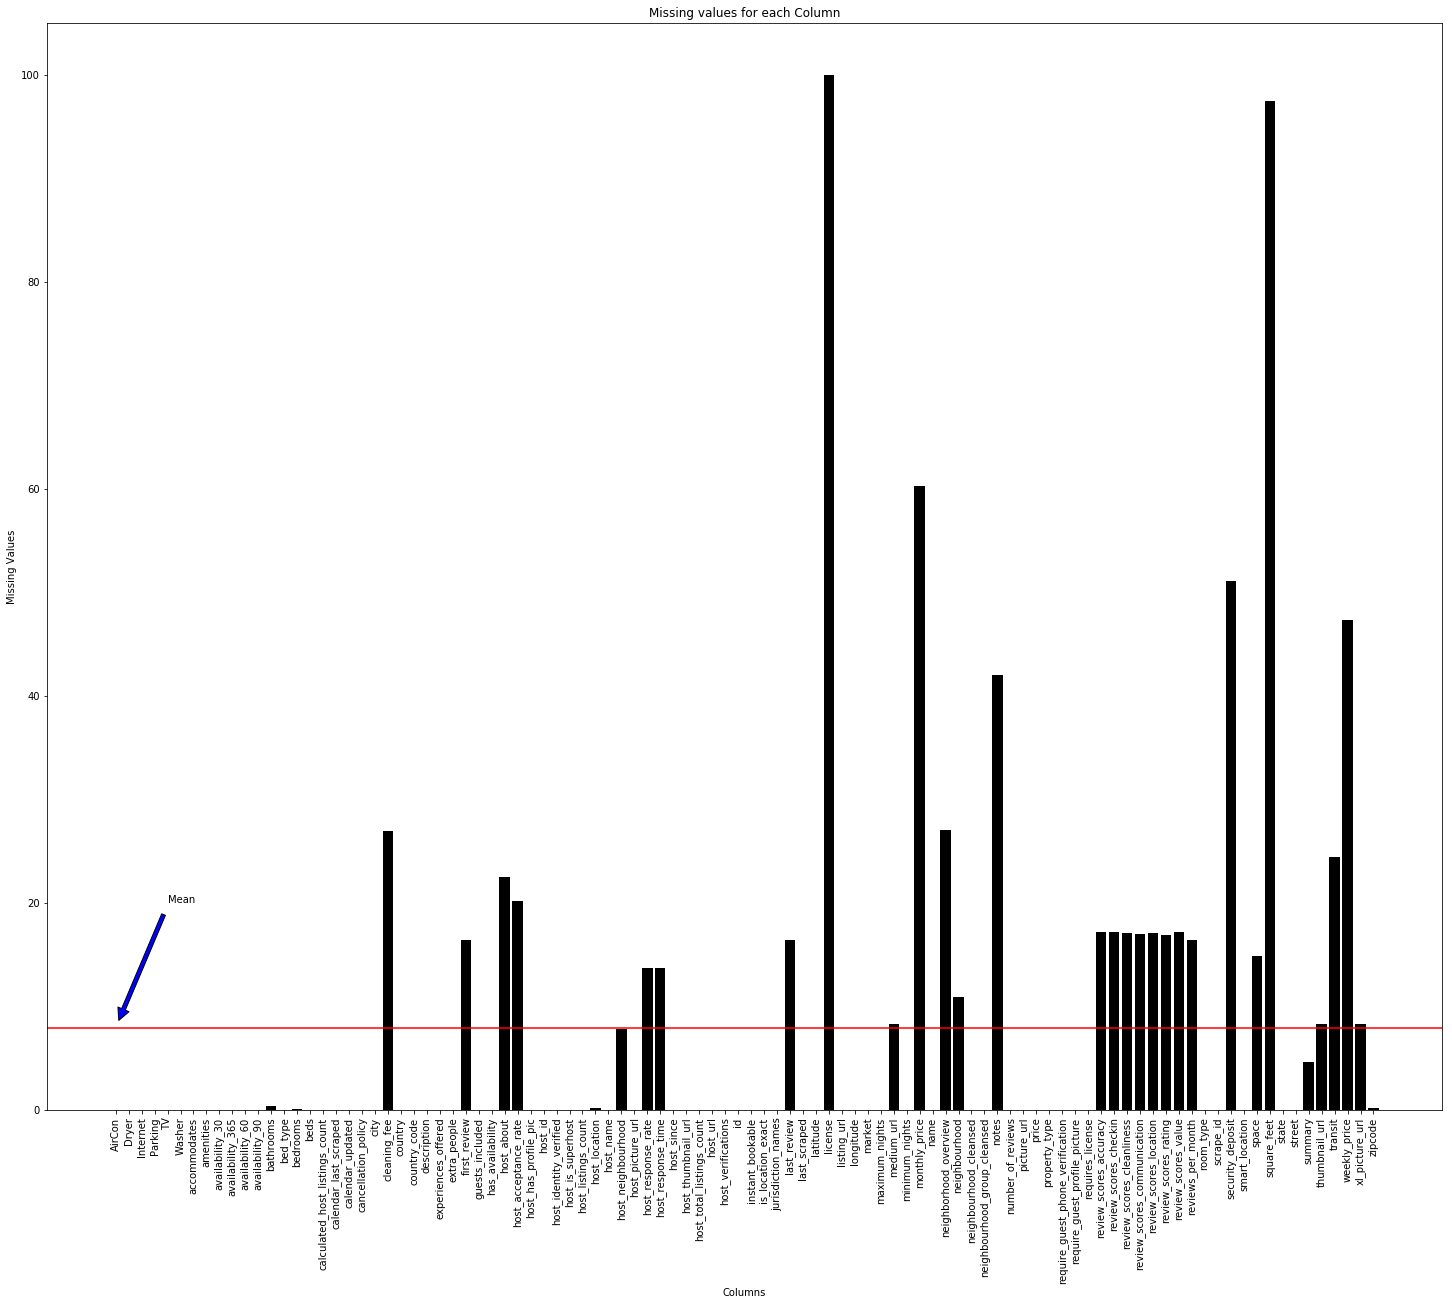

In [13]:
# Addressing missing values
# Visualize missing values
# List comprehensions for headers and corresponding missing values where series has missing values
missing_percent = [(listings[series].isnull().sum()/len(listings[series]))*100 for series in list(listings) ]
headers_missing = [series for series in list(listings)  ]

mean = np.mean(missing_percent)
fig, ax = plt.pyplot.subplots(figsize=(25,20))
plt.pyplot.title("Missing values for each Column")
plt.pyplot.xlabel("Columns")
plt.pyplot.ylabel("Missing Values")
plt.pyplot.axhline(y=mean, c='r', label='"Mean"')

ax.annotate('Mean', xy=(0, mean), xytext=(4, 20),
            arrowprops=dict(facecolor='blue', shrink=0.06),
            )
plt.pyplot.bar(headers_missing, missing_percent,color="black")
plt.pyplot.xticks(rotation=90);

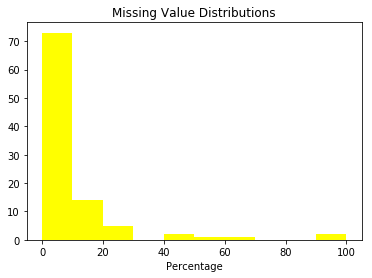

In [12]:
# Get a missingvalue distribution in order to set a cut-off point for missing values
plt.pyplot.title("Missing Value Distributions")
plt.pyplot.xlabel("Percentage")
plt.pyplot.hist(missing_percent,color="yellow");


Removing columns with 25% missing values or more as they are outliers in this dataset.


In [15]:
# Remove outlier columns
def remove_outlier_col(df, thresh):
    """
    Function to identify outlier columns. 
    Takes dataframe and outlier threshold as input, returns two lists. 
    First list identifies the columns and the second contains coresponding number of missing values
    """
    outlier_columns = []
    outlier_value = []
    for i in list(df):
        if ((df[i].isnull().sum() / len(df[i])) > thresh):
           
            outlier_columns.append(i)
            outlier_value.append(df[i].isnull().sum())
        
    return outlier_columns, outlier_value

In [17]:
outlier_col, outlier_value = remove_outlier_col(listings, 0.25)

In [18]:
for i in zip(outlier_col, outlier_value):
    print(i)

('neighborhood_overview', 1032)
('notes', 1606)
('square_feet', 3721)
('weekly_price', 1809)
('monthly_price', 2301)
('security_deposit', 1952)
('cleaning_fee', 1030)
('license', 3818)


In [19]:
listings.drop(outlier_col, axis=1, inplace=True)

In [20]:
# Categorical features
# I used this cell for analyzing which string columns to keep and which to drop
list(listings.select_dtypes(include=['object']))

['listing_url',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'transit',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'is_location_exact',
 'property_type',
 'room_type',
 'bed_type',
 'amenities',
 'price',
 'extra_people',
 'calendar_updated',
 'has_availability',
 'calendar_last_scraped',
 'first_review',
 'last_review',
 'requires_license',
 'jurisdiction_names',
 'instant_bookable',
 'cancellation_policy',
 'require_guest_profile_pictu

In [21]:
# But scrape_id contains the same value for all rows and that host_listings_count is the same as host_total_listings_count
listings.drop(['scrape_id', 'host_listings_count'], axis=1, inplace=True)

In [22]:
# These are the features to be reencoded and to make numeric out of the categorical features. 
# Decision is based on data distribution in each feature. whether another feature allready explains the same and how relevant i belive
# the feature is.

one_hot_encode = ['cancellation_policy', 'neighbourhood_group_cleansed', 'property_type', 'bed_type', 'host_identity_verified',
                  'host_response_time', 'host_is_superhost', 'room_type', 'instant_bookable']
    
make_numeric = ['host_response_rate', 'price', 'extra_people' ]

In [23]:
# Convert to numeric values
listings.host_response_rate = listings.host_response_rate.str.replace("%", "")
listings.host_response_rate = pd.to_numeric(listings.host_response_rate)

listings.price = listings.price.str.replace("$", "")
listings.price = listings.price.str.replace(",", "")
listings.price = pd.to_numeric(listings.price)

listings.extra_people = listings.extra_people.str.replace("$", "")
listings.extra_people = pd.to_numeric(listings.extra_people);

In [24]:
list(listings.select_dtypes(include=['object']));

In [25]:
drop_num = ['id', 'host_id', 'latitude', 'longitude', 'review_scores_accuracy', 'review_scores_cleanliness',
            'review_scores_communication', 'review_scores_location', 'review_scores_checkin','review_scores_value', 
            'reviews_per_month', 'calculated_host_listings_count']

drop_object = [i for i in list(listings.select_dtypes(include=['object'])) if i not in make_numeric + one_hot_encode]

In [26]:
listings.drop(drop_num + drop_object, axis=1, inplace=True)


The dataset contains several redundant features and some features with highly skewed distributions.
After a manual check of each of the features,it is decided to drop all the features in the list 
drop_num


In [28]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 32 columns):
host_response_time              3295 non-null object
host_response_rate              3295 non-null float64
host_is_superhost               3816 non-null object
host_total_listings_count       3816 non-null float64
host_identity_verified          3816 non-null object
neighbourhood_group_cleansed    3818 non-null object
property_type                   3817 non-null object
room_type                       3818 non-null object
accommodates                    3818 non-null int64
bathrooms                       3802 non-null float64
bedrooms                        3812 non-null float64
beds                            3817 non-null float64
bed_type                        3818 non-null object
price                           3818 non-null float64
guests_included                 3818 non-null int64
extra_people                    3818 non-null float64
minimum_nights                  3818 non


Visualizing correlations through heatmap:


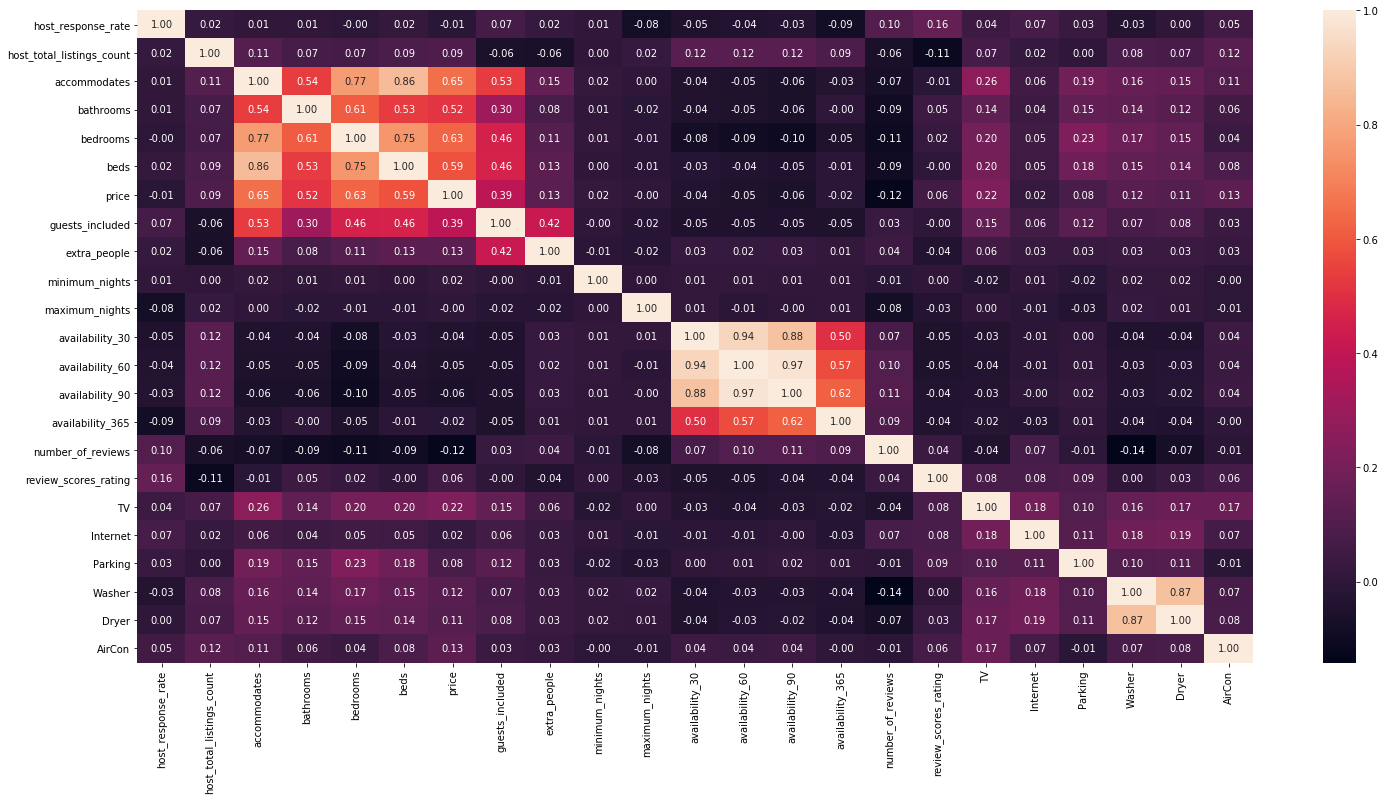

In [30]:
fig, ax = plt.pyplot.subplots(figsize=(25,12))
sns.heatmap(listings.corr(), annot=True, fmt='.2f');


As can be seen in the heatmap, some of these features correlate very high. 
Features that correlate more than 60 % with another are dropped in order to make sure that they remain independent.
Its also clear that beds and bedrooms are latent features of "accommodates"


In [32]:
highcorr = ['beds', 'bedrooms', 'availability_60', 'availability_90', 'availability_365', 'Dryer']

listings.drop(highcorr, axis=1, inplace=True)


The "Accommodates" feature was highly correlated with price but it seems to be some outlier datapoints. One listing can accommodate Eleven people and the price ($1000) is by far the highests of them all. So it is decided to only keep rows with accommodation upto 8 people.


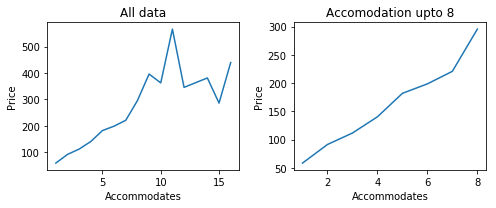

In [34]:
accom = pd.DataFrame(listings.groupby("accommodates")['price'].mean(), columns=['price'])

f,a = plt.pyplot.subplots(figsize=(7,3))
plt.pyplot.subplot(1,2,1)
plt.pyplot.title("All data")
plt.pyplot.ylabel("Price")
plt.pyplot.xlabel("Accommodates")
plt.pyplot.plot(accom)

plt.pyplot.subplot(1,2,2)
plt.pyplot.title("Accomodation upto 8")
plt.pyplot.ylabel("Price")
plt.pyplot.xlabel("Accommodates")
plt.pyplot.plot(accom[:8])

plt.pyplot.tight_layout();

In [35]:
# Drop listings that can accommodate more than 8 people as its very noisy 
listings = listings[listings.accommodates <= 8]


NEW HEATMAP:


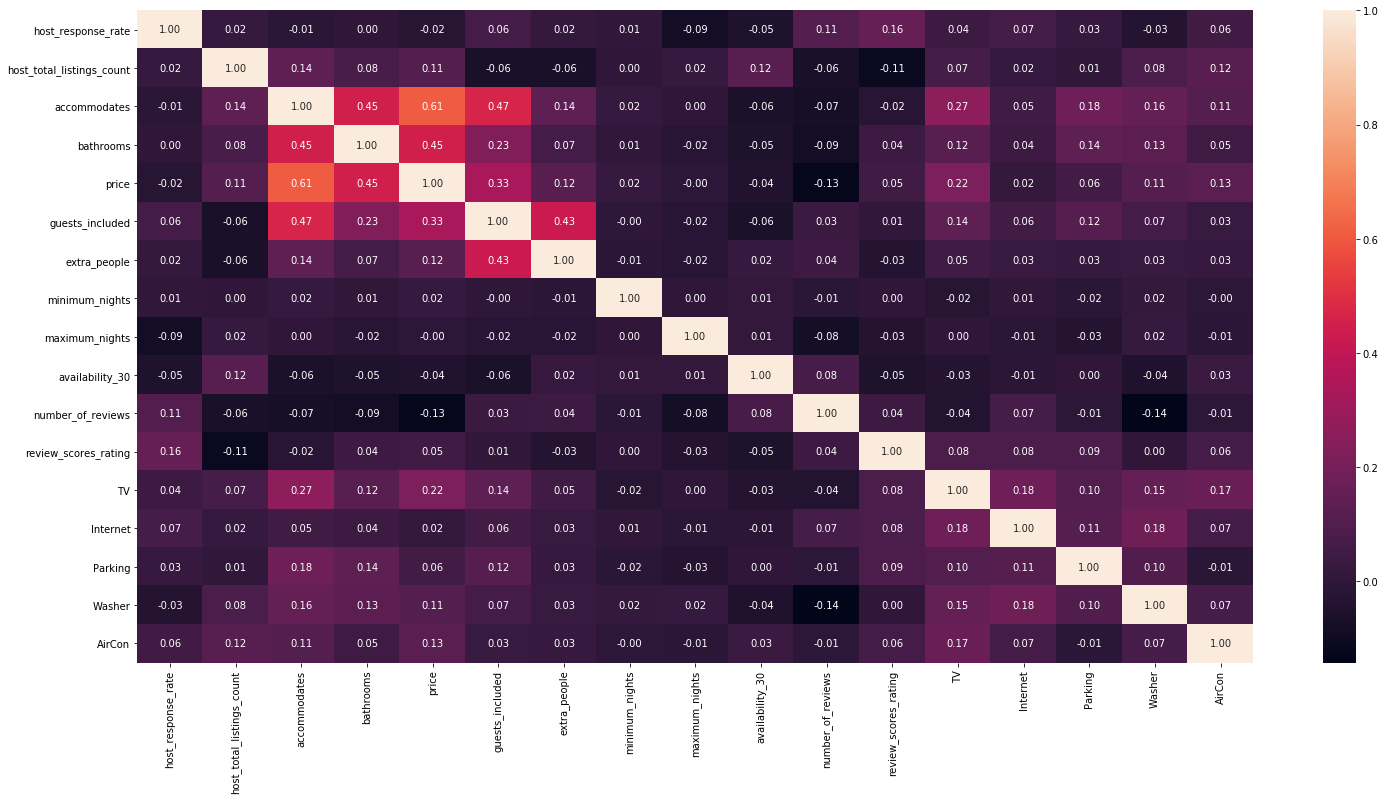

In [37]:
fig, ax = plt.pyplot.subplots(figsize=(25,12))
sns.heatmap(listings.corr(), annot=True, fmt='.2f');


The heatmap only contains numerical data. 
I will also look at location in the next part with descriptive statistics.


In [39]:
# Mean listings price per neigbourhood
hood = pd.DataFrame(listings.groupby('neighbourhood_group_cleansed')['price'].mean().sort_values(ascending=False))
hood['data_points'] = listings.neighbourhood_group_cleansed.value_counts()
hood

,price,data_points
neighbourhood_group_cleansed,,
Magnolia,166.600000,55
Downtown,152.388258,528
Queen Anne,149.314879,289
Cascade,140.101124,89
West Seattle,138.181818,198
Central Area,123.047222,360
Capitol Hill,122.230631,555
Ballard,118.964444,225
Other neighborhoods,117.512723,786



QUESTION 1: How to get the best price for the Airbnb Listing?
* By accommodating as many people as possible in order to get the best price on AirBNB. 
* The listings needs to be in the right area and its also important to get good reviews but not as important as to accommodate as many as possible. 
* Having a TV and a Parking spot is also adviced as well as a Washer and Air conditioner.



QUESTION 2: How to achive better reviews for the listings?


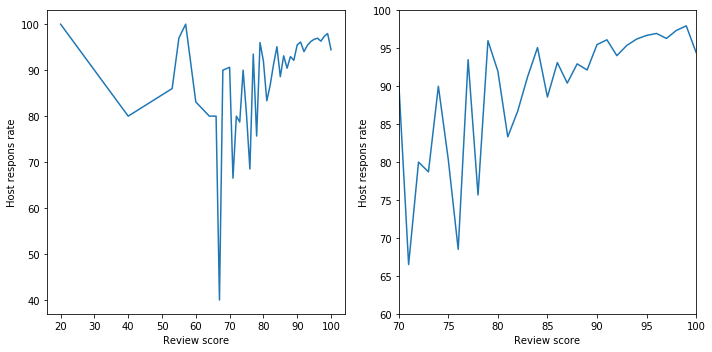

In [42]:
# visulizing the relationship between resonse rate and review score
host = pd.DataFrame(listings.groupby('review_scores_rating')['host_response_rate'].mean())
plt.pyplot.subplots(figsize=(10,5))
plt.pyplot.title("Response rate vs review score")
plt.pyplot.subplot(1,2,1)
plt.pyplot.plot(host)
plt.pyplot.ylabel("Host respons rate")
plt.pyplot.xlabel("Review score")

# data under 70 for review score seems noisy so i made a subplot for datapoints above
plt.pyplot.subplot(1,2,2)
plt.pyplot.plot(host)
plt.pyplot.ylabel("Host respons rate")
plt.pyplot.xlabel("Review score")
plt.pyplot.xlim(70,100)
plt.pyplot.ylim(60,100)

plt.pyplot.tight_layout()


To get the best reviews, you should:
* Not have too many listings
* Respond on every inquiry you get
* Dont have limitations on nights to stay
* Inclusion of amenities like Parking space, TV and Internet
* High availibility 



QUESTION 3: Predicting listing price with Machine Learning


In [45]:
# One hot encode categorical features before machine learning
listings_ohe = pd.get_dummies(listings, drop_first=True);

In [46]:
# Split dataset into subsets for different handling of missing values
full_df = listings_ohe.dropna().copy()

imputed_df = listings_ohe.copy()
for col in imputed_df:
    imputed_df[col].fillna(imputed_df[col].value_counts().index[0], inplace=True)

In [47]:
# Length of each dataset
print("Length full_df : ", len(full_df),
      "Length of imputed_df : ", len(imputed_df))

Length full_df :  2794 Length of imputed_df :  3753


In [48]:
# Split into targets and features
target = full_df.price.copy()
features = full_df.drop('price', axis=1).copy()

target_imp = imputed_df.price.copy()
features_imp = imputed_df.drop('price', axis=1).copy()

In [94]:
# Split to training set and testing set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.125)

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(features_imp, target_imp, test_size=0.093)


ADABoost:


In [51]:
param_dist = {
 'n_estimators': [500, 2000],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }



adamodel = RandomizedSearchCV(AdaBoostRegressor(), param_distributions = param_dist, cv=3, n_iter = 20, n_jobs=-1);
                              
adamodel.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': [500, 2000], 'learning_rate': [0.01, 0.05, 0.1, 0.3, 1], 'loss': ['linear', 'square', 'exponential']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [95]:
y_pred = adamodel.predict(X_test_imp)

In [96]:
r2_score(y_test, y_pred)

-0.90128478256622224


SVM:
* SVM requires normalization of the data in order to get good results. 
* If not some features will be given more weights than others. 
* Here I have used Standardscaler to make sure all features gets evaluated equally.


In [98]:
scaler = preprocessing.StandardScaler()

scaled_x = scaler.fit_transform(X_train)
test_x = scaler.transform(X_test)
scaled_x_imp = scaler.fit_transform(X_train_imp)
test_x_imp = scaler.transform(X_test_imp)

In [99]:
param_dist_svm = {
 'kernel': ['linear', 'rbf', 'poly'],
 'C' : [0.001,0.05,0.1]

 }

svmmodel = GridSearchCV(svm.SVC(), param_grid=param_dist_svm )
svmmodel.fit(scaled_x_imp, y_train_imp)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['linear', 'rbf', 'poly'], 'C': [0.001, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [100]:
svmpred = svmmodel.predict(test_x_imp)
r2_score(y_test_imp, svmpred)

0.48205870718820198


Randomforest:


In [102]:
from scipy.stats import randint
# specify parameters and distributions to sample from
param_dist = {"max_depth": randint(3,15),
              "n_estimators" : [100, 1000],
              "min_samples_split": randint(2, 11),
              "bootstrap": [True, False],
              "min_samples_leaf" : randint(1,10)
                            }
n_iter_search = 20
randommodel = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)
randommodel.fit(X_train_imp, y_train_imp);

In [103]:
pred = randommodel.predict(X_test_imp)

In [104]:
r2_score(y_test_imp, pred)

0.56663972389606365


CONCLUSION:
* The best model was Random Forest. 
* It did several experiments on imputaion on the missing data, adding and removing features and 
different hypertuning. 
* Random Forest came out on top every time.  



The ML model predicts good for a variance of 57%.
